In [1]:
import pandas as pd, os

In [2]:
# Load db-related packages
import pandas.io.sql as psql
import mysql.connector as mysql
%load_ext dotenv
%dotenv db.env

# Establish db connection
connection = mysql.connect(user = os.getenv('DB_USERNAME'),password = os.getenv('DB_PASSWORD'),database = os.getenv('DB_DATABASE'),host = os.getenv('DB_HOST'))
cursor = connection.cursor()

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## Recency

In [4]:
sql = """
SELECT c.name AS customer_name, DATEDIFF('2005-06-01',MAX(o.order_date)) AS days_since_last_order
FROM customers c 
    LEFT JOIN orders o ON c.customer_no = o.customer_no
WHERE o.status = 'Shipped'
GROUP BY c.name
ORDER BY days_since_last_order DESC
;
"""

df_recency = psql.read_sql(sql, connection).fillna(0)
df_recency

/Users/developer/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,customer_name,days_since_last_order
0,Toys4GrownUps.com,561
1,"King Kong Collectables, Co.",548
2,"Men 'R' US Retailers, Ltd.",509
3,"Double Decker Gift Stores, Ltd",496
4,West Coast Collectables Co.,489
...,...,...
93,Euro+ Shopping Channel,29
94,Gift Depot Inc.,27
95,L'ordine Souveniers,22
96,"Extreme Desk Decorations, Ltd",16


<AxesSubplot:>

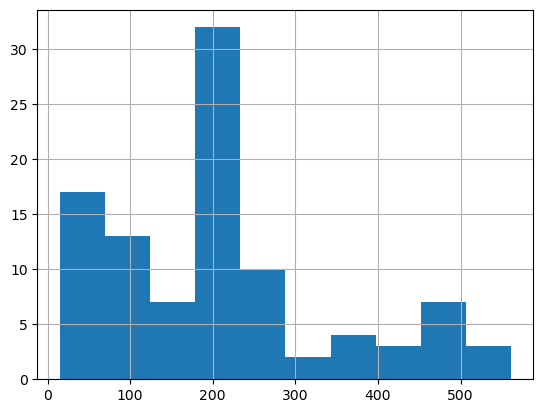

In [5]:
df_recency.days_since_last_order.hist()

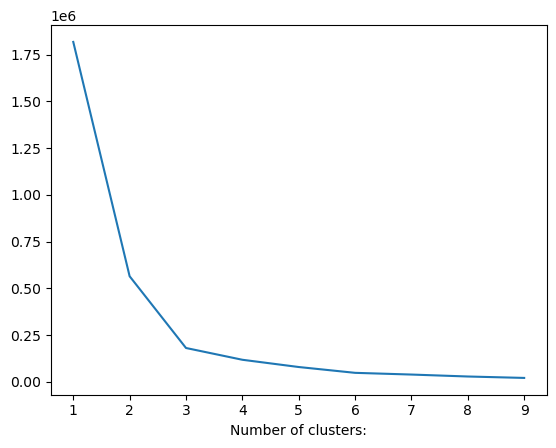

In [6]:
sse={}
df = df_recency[['days_since_last_order']].copy(deep=True)

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters:")
plt.show()

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 3.

In [7]:
kmeans = KMeans(n_clusters=3,random_state=123)
kmeans.fit(df_recency[['days_since_last_order']])
df_recency['r_cluster'] = kmeans.predict(df_recency[['days_since_last_order']])

In [8]:
df_recency

,customer_name,days_since_last_order,r_cluster
0,Toys4GrownUps.com,561,1
1,"King Kong Collectables, Co.",548,1
2,"Men 'R' US Retailers, Ltd.",509,1
3,"Double Decker Gift Stores, Ltd",496,1
4,West Coast Collectables Co.,489,1
...,...,...,...
93,Euro+ Shopping Channel,29,2
94,Gift Depot Inc.,27,2
95,L'ordine Souveniers,22,2
96,"Extreme Desk Decorations, Ltd",16,2


In [10]:
df_recency.groupby(by='r_cluster').describe()

days_since_last_order                                              \
                          count        mean        std    min    25%    50%   
r_cluster                                                                     
0                          49.0  211.857143  40.062971  142.0  188.0  208.0   
1                          18.0  447.111111  63.509044  334.0  395.0  458.5   
2                          31.0   68.064516  34.183754   15.0   39.5   63.0   

                          
              75%    max  
r_cluster                 
0          231.00  315.0  
1          486.25  561.0  
2           90.50  132.0

## Frequency

In [11]:
sql = """
SELECT c.name AS customer_name, COUNT(DISTINCT order_no) AS total_order_count
FROM customers c 
    LEFT JOIN orders o ON c.customer_no = o.customer_no
WHERE o.status = 'Shipped'
GROUP BY c.name
ORDER BY total_order_count DESC
;
"""

df_frequency = psql.read_sql(sql, connection).fillna(0)
df_frequency

/Users/developer/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,customer_name,total_order_count
0,Euro+ Shopping Channel,22
1,Mini Gifts Distributors Ltd.,16
2,"Australian Collectors, Co.",5
3,"Dragon Souveniers, Ltd.",5
4,"Down Under Souveniers, Inc",5
...,...,...
93,Mini Auto Werke,2
94,Mini Classics,2
95,"Norway Gifts By Mail, Co.",2
96,Online Mini Collectables,2


<AxesSubplot:>

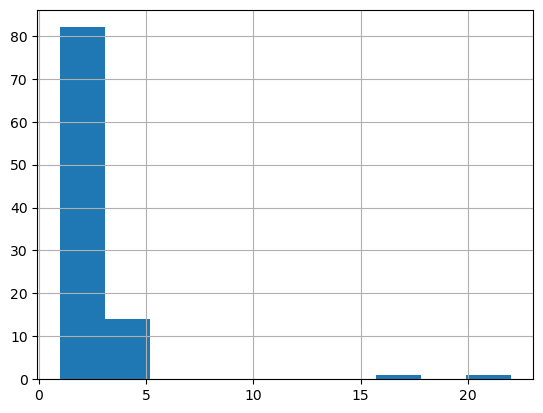

In [12]:
df_frequency.total_order_count.hist()

/var/folders/dx/3ksrp4xx1gz70zw3w9kpx7_00000gq/T/ipykernel_13300/796458819.py:5: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
/var/folders/dx/3ksrp4xx1gz70zw3w9kpx7_00000gq/T/ipykernel_13300/796458819.py:5: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)


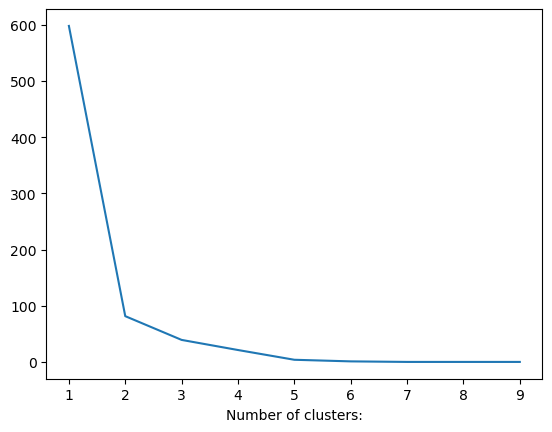

In [13]:
sse={}
df = df_frequency[['total_order_count']].copy(deep=True)

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters:")
plt.show()

In [14]:
kmeans = KMeans(n_clusters=3,random_state=123)
kmeans.fit(df_frequency[['total_order_count']])
df_frequency['f_cluster'] = kmeans.predict(df_frequency[['total_order_count']])

In [15]:
df_frequency

,customer_name,total_order_count,f_cluster
0,Euro+ Shopping Channel,22,1
1,Mini Gifts Distributors Ltd.,16,1
2,"Australian Collectors, Co.",5,2
3,"Dragon Souveniers, Ltd.",5,2
4,"Down Under Souveniers, Inc",5,2
...,...,...,...
93,Mini Auto Werke,2,0
94,Mini Classics,2,0
95,"Norway Gifts By Mail, Co.",2,0
96,Online Mini Collectables,2,0


In [16]:
df_frequency.groupby(by='f_cluster').describe()

total_order_count                                                \
                      count       mean       std   min   25%   50%    75%   
f_cluster                                                                   
0                      40.0   1.975000  0.158114   1.0   2.0   2.0   2.00   
1                       2.0  19.000000  4.242641  16.0  17.5  19.0  20.50   
2                      56.0   3.321429  0.606245   3.0   3.0   3.0   3.25   

                 
            max  
f_cluster        
0           2.0  
1          22.0  
2           5.0

## Monetary

In [17]:
sql = """
SELECT c.name AS customer_name, SUM(od.price_each * od.quantity_ordered) AS total_amount_sold
FROM customers c
    LEFT JOIN orders o ON c.customer_no = o.customer_no
    LEFT JOIN order_details od ON od.order_no = o.order_no
WHERE o.status = 'Shipped'
GROUP BY c.name
ORDER BY total_amount_sold DESC
;
"""

df_monetary = psql.read_sql(sql, connection)
df_monetary

/Users/developer/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,customer_name,total_amount_sold
0,Euro+ Shopping Channel,668770.46
1,Mini Gifts Distributors Ltd.,584188.24
2,"Australian Collectors, Co.",180585.07
3,Muscle Machine Inc,177913.95
4,"Dragon Souveniers, Ltd.",156251.03
...,...,...
93,Frau da Collezione,25358.32
94,Mini Auto Werke,23938.09
95,Atelier graphique,22314.36
96,Auto-Moto Classics Inc.,21554.26


<AxesSubplot:>

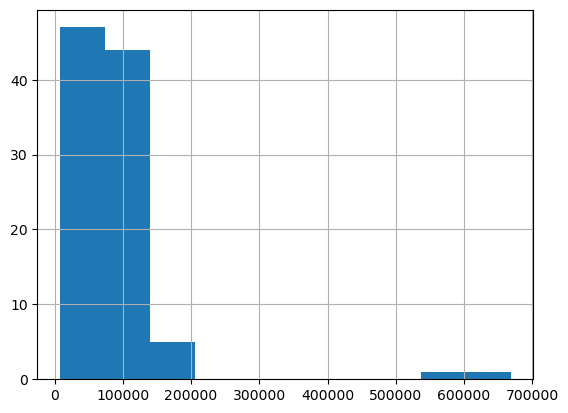

In [18]:
df_monetary.total_amount_sold.hist()

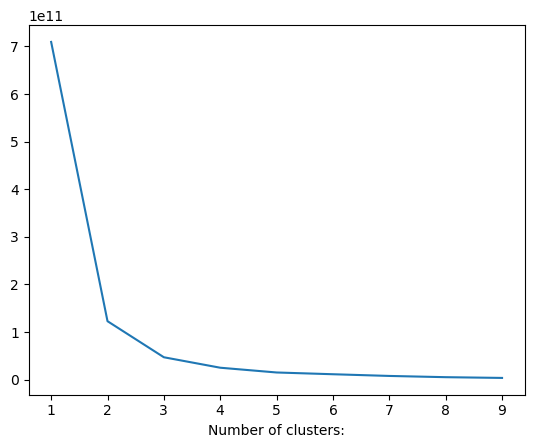

In [19]:
sse={}
df = df_monetary[['total_amount_sold']].copy(deep=True)

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
    df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters:")
plt.show()

In [20]:
kmeans = KMeans(n_clusters=3,random_state=123)
kmeans.fit(df_monetary[['total_amount_sold']])
df_monetary['m_cluster'] = kmeans.predict(df_monetary[['total_amount_sold']])

In [21]:
df_monetary

,customer_name,total_amount_sold,m_cluster
0,Euro+ Shopping Channel,668770.46,1
1,Mini Gifts Distributors Ltd.,584188.24,1
2,"Australian Collectors, Co.",180585.07,2
3,Muscle Machine Inc,177913.95,2
4,"Dragon Souveniers, Ltd.",156251.03,2
...,...,...,...
93,Frau da Collezione,25358.32,0
94,Mini Auto Werke,23938.09,0
95,Atelier graphique,22314.36,0
96,Auto-Moto Classics Inc.,21554.26,0


In [22]:
df_monetary.groupby(by='m_cluster').describe()

total_amount_sold                                          \
                      count           mean           std        min   
m_cluster                                                             
0                      56.0   55551.715893  18720.563298    7918.60   
1                       2.0  626479.350000  59808.661330  584188.24   
2                      40.0  112530.996250  24958.813969   86436.97   

                                                           
                   25%         50%         75%        max  
m_cluster                                                  
0           43403.0800   59679.885   70186.305   82223.23  
1          605333.7950  626479.350  647624.905  668770.46  
2           91568.3875  105046.975  127119.815  180585.07

## Clustering

In [23]:
df_customers = df_recency.merge(df_frequency,how='left', left_on='customer_name', right_on='customer_name').merge(df_monetary,how='left', left_on='customer_name', right_on='customer_name')
df_customers

,customer_name,days_since_last_order,r_cluster,total_order_count,f_cluster,total_amount_sold,m_cluster
0,Toys4GrownUps.com,561,1,2,0,54222.70,0
1,"King Kong Collectables, Co.",548,1,2,0,45480.79,0
2,"Men 'R' US Retailers, Ltd.",509,1,2,0,41506.19,0
3,"Double Decker Gift Stores, Ltd",496,1,2,0,29586.15,0
4,West Coast Collectables Co.,489,1,2,0,43748.72,0
...,...,...,...,...,...,...,...
93,Euro+ Shopping Channel,29,2,22,1,668770.46,1
94,Gift Depot Inc.,27,2,3,2,95424.63,2
95,L'ordine Souveniers,22,2,3,2,125505.57,2
96,"Extreme Desk Decorations, Ltd",16,2,3,2,90332.38,2


In [34]:
df_customers['overall_score'] = df_customers['r_cluster'] + df_customers['f_cluster'] + df_customers['m_cluster']
df_customers.groupby('overall_score')['days_since_last_order','total_order_count','total_amount_sold'].mean().style.format('{:,.2f}'.format)


/var/folders/dx/3ksrp4xx1gz70zw3w9kpx7_00000gq/T/ipykernel_13300/652207231.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_customers.groupby('overall_score')['days_since_last_order','total_order_count','total_amount_sold'].mean().style.format('{:,.2f}'.format)


,days_since_last_order,total_order_count,total_amount_sold
overall_score,,,
0,251.20,1.93,"57,869.29"
1,452.12,2.00,"49,066.49"
2,170.43,2.70,"62,371.55"
4,151.50,4.54,"145,913.27"
5,407.00,3.00,"108,593.49"
6,64.83,3.61,"114,352.23"


In [33]:
df_customers.groupby('overall_score')['days_since_last_order','total_order_count','total_amount_sold'].median().style.format('{:,.2f}'.format)

/var/folders/dx/3ksrp4xx1gz70zw3w9kpx7_00000gq/T/ipykernel_13300/1227973130.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_customers.groupby('overall_score')['days_since_last_order','total_order_count','total_amount_sold'].median().style.format('{:,.2f}'.format)


,days_since_last_order,total_order_count,total_amount_sold
overall_score,,,
0,258.00,2.00,"58,876.41"
1,463.50,2.00,"45,200.78"
2,188.00,3.00,"69,214.33"
4,174.00,3.00,"102,884.63"
5,407.00,3.00,"108,593.49"
6,61.00,3.00,"111,121.97"


### Customer Segments

*Lost* 
- 1,5

*Sleepers*
- 0,2

*Needs Attention*
- 4

*Loyal Customers*
- 6
